In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-comments-dataset/YoutubeCommentsDataSet.csv


In [2]:
df=pd.read_csv("/kaggle/input/youtube-comments-dataset/YoutubeCommentsDataSet.csv")
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


In [4]:
df.isnull().sum()

Comment      44
Sentiment     0
dtype: int64

In [5]:
df.duplicated().sum()

531

In [6]:
df.drop_duplicates(inplace=True)


In [7]:
df.duplicated().sum()

0

In [8]:
df['Comment'].fillna('Unknown', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17877 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    17877 non-null  object
 1   Sentiment  17877 non-null  object
dtypes: object(2)
memory usage: 419.0+ KB


<ipython-input-8-125af7707b1a>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Comment'].fillna('Unknown', inplace=True)


In [9]:
df['Sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Embedding, SpatialDropout1D, Bidirectional, 
                                     LSTM, Dense, Dropout, LayerNormalization, 
                                     Attention, Input, Flatten)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

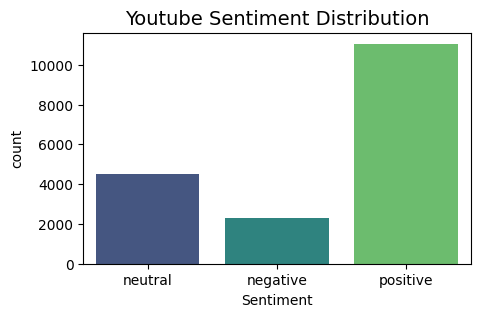

In [11]:
plt.figure(figsize=(5, 3))
sns.countplot(x='Sentiment', data=df, palette='viridis')
plt.title('Youtube Sentiment Distribution', fontsize=14)
plt.show()

In [12]:
le= LabelEncoder()
df['Sentiment'] = le.fit_transform(df['Sentiment'])
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,1
1,here in nz 50 of retailers don’t even have con...,0
2,i will forever acknowledge this channel with t...,2
3,whenever i go to a place that doesn’t take app...,0
4,apple pay is so convenient secure and easy to ...,2


In [13]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [14]:
import re
import contractions
def clean_text(text):
    text = str(text).lower() # Convert to lowercase
    text = contractions.fix(text) # Expand contractions
    text = re.sub(r"http\S+|www\.\S+", "", text) # Remove URLs starting with http/https or www
    text = re.sub(r"@\w+", "", text)  # Remove mentions (@usernames) to avoid irrelevant tokens
    text = re.sub(r"[^a-z0-9' ]", "", text) # Remove special characters
    text = re.sub(r"\s+", " ", text).strip() # Remove extra spaces
    return text

# Apply text cleaning function to the "Comment" column before model training
df["Cleaned_Text"] = df["Comment"].apply(clean_text)

In [15]:
df.head()

,Comment,Sentiment,Cleaned_Text
0,lets not forget that apple pay in 2014 require...,1,let us not forget that apple pay in 2014 requi...
1,here in nz 50 of retailers don’t even have con...,0,here in nz 50 of retailers do not even have co...
2,i will forever acknowledge this channel with t...,2,i will forever acknowledge this channel with t...
3,whenever i go to a place that doesn’t take app...,0,whenever i go to a place that does not take ap...
4,apple pay is so convenient secure and easy to ...,2,apple pay is so convenient secure and easy to ...


In [16]:
X= df['Cleaned_Text']

y= df['Sentiment']

In [17]:
max_words = 7500
max_length = 60

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X)

X_sequences = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(X_sequences, maxlen = max_length, padding = "post", truncating = "post")







In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, stratify =y, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 128
lstm_units = 64

model = Sequential([
    Embedding(input_dim=7500, output_dim=embedding_dim, input_length=60),
    LSTM(lstm_units, return_sequences=True),
    Dropout(0.2),
    LSTM(lstm_units),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# 🔹 Explicitly call build with the correct input shape
model.build(input_shape=(None, 60))

# Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 60, 128)             │         960,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,044,545 (3.98 MB)

 Trainable params: 1,044,545 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.2520 - loss: -34.0288 - val_accuracy: 0.2520 - val_loss: -248.5770
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.2546 - loss: -380.3629 - val_accuracy: 0.2520 - val_loss: -917.9293
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.2514 - loss: -1150.1707 - val_accuracy: 0.2520 - val_loss: -1951.6288
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.2477 - loss: -2313.8167 - val_accuracy: 0.2520 - val_loss: -3312.1790
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.2520 - loss: -3715.8328 - val_accuracy: 0.2520 - val_loss: -4959.1147
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.2559 - loss: -5432.8799 - val_accuracy: 0.2520 - val_loss: -6877.5483
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.2497 - loss: -7416.6245 - val_accuracy: 0.2520 - val_loss: -9024.0195
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2378 - loss: -17012.6992
Test Accuracy: 0.2520


In [22]:
predictions = model.predict(X_test)
print("Prediction:", predictions)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Prediction: [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [23]:
print("Unique Labels:", np.unique(y_train))
print("Label Shape:", y_train.shape)

Unique Labels: [0 1 2]
Label Shape: (14301,)


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Using unigrams and bigrams

# Transform cleaned text into numerical features
X_tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Text'])

# Convert to DataFrame (optional)
import pandas as pd
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display some features
print(X_tfidf_df.head())


   000  0000  0018  0018 joonie   10  10 years  100  1000  100k  1010  ...  \
0  0.0   0.0   0.0          0.0  0.0       0.0  0.0   0.0   0.0   0.0  ...   
1  0.0   0.0   0.0          0.0  0.0       0.0  0.0   0.0   0.0   0.0  ...   
2  0.0   0.0   0.0          0.0  0.0       0.0  0.0   0.0   0.0   0.0  ...   
3  0.0   0.0   0.0          0.0  0.0       0.0  0.0   0.0   0.0   0.0  ...   
4  0.0   0.0   0.0          0.0  0.0       0.0  0.0   0.0   0.0   0.0  ...   

   your work  yours  yourself  youtube  youtube channel  youtuber  youtubers  \
0        0.0    0.0       0.0      0.0              0.0       0.0        0.0   
1        0.0    0.0       0.0      0.0              0.0       0.0        0.0   
2        0.0    0.0       0.0      0.0              0.0       0.0        0.0   
3        0.0    0.0       0.0      0.0              0.0       0.0        0.0   
4        0.0    0.0       0.0      0.0              0.0       0.0        0.0   

   yummy  zero  zoom  
0    0.0   0.0   0.0  
1   

In [25]:
from sklearn.model_selection import train_test_split

# Define input (features) and output (target)
X = X_tfidf  # TF-IDF transformed features
y = df['Sentiment']  # Target variable (positive, negative, neutral)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data successfully split into training and test sets!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Data successfully split into training and test sets!
Training samples: 14301
Test samples: 3576


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd



In [27]:
logistic = LogisticRegression(max_iter=500, random_state=42)
logistic.fit(X_train, y_train)

log_pred = logistic.predict(X_test)

accuracy = accuracy_score(y_test, log_pred)
report = classification_report(y_test, log_pred, output_dict=True)

results[name] = {
        "Accuracy": accuracy,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"]
    }

results_df = pd.DataFrame(results).T
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

# Display results
print("\nModel Performance Comparison:")
print(results_df)

NameError: name 'results' is not defined

In [ ]:
results = {}
name1 = "Random Forest Classifier"
random = RandomForestClassifier(n_estimators=100, random_state=42)
random.fit(X_train, y_train)

random_pred = random.predict(X_test)

accuracy = accuracy_score(y_test, random_pred)
report = classification_report(y_test, random_pred, output_dict=True)

results[name1] = {
        "Accuracy": accuracy,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"]
    }

results_df = pd.DataFrame(results).T
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

# Display results
print("\nModel Performance Comparison:")
print(results_df)

In [ ]:
results = {}
name1 = "Gradient Boosting Classifier"
gradien = GradientBoostingClassifier(n_estimators=100, random_state=42)
gradien.fit(X_train, y_train)

gradien_pred = gradien.predict(X_test)

accuracy = accuracy_score(y_test, gradien_pred)
report = classification_report(y_test, gradien_pred, output_dict=True)

results[name1] = {
        "Accuracy": accuracy,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"]
    }

results_df = pd.DataFrame(results).T
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

# Display results
print("\nModel Performance Comparison:")
print(results_df)

In [ ]:
results = {}
name1 = "XGB Calssifier"
xgbc = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgbc.fit(X_train, y_train)

xgbc_pred = xgbc.predict(X_test)

accuracy = accuracy_score(y_test, xgbc_pred)
report = classification_report(y_test, xgbc_pred, output_dict=True)

results[name1] = {
        "Accuracy": accuracy,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"]
    }

results_df = pd.DataFrame(results).T
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

# Display results
print("\nModel Performance Comparison:")
print(results_df)

In [ ]:
results = {}
name1 = "SVC"
svc = SVC(kernel="rbf")
svc.fit(X_train, y_train)

svc_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, svc_pred)
report = classification_report(y_test, svc_pred, output_dict=True)

results[name1] = {
        "Accuracy": accuracy,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"]
    }

results_df = pd.DataFrame(results).T
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

# Display results
print("\nModel Performance Comparison:")
print(results_df)

In [ ]:
results = {}
name1 = "MLP Classifier"
mlpc = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlpc.fit(X_train, y_train)

mlpc_pred = mlpc.predict(X_test)

accuracy = accuracy_score(y_test, mlpc_pred)
report = classification_report(y_test, mlpc_pred, output_dict=True)

results[name1] = {
        "Accuracy": accuracy,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"]
    }

results_df = pd.DataFrame(results).T
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

# Display results
print("\nModel Performance Comparison:")
print(results_df)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model performance data
models = ["Logistic Regression", "Random Forest", "Gradient Boosting", "XGBoost", "MLP", "SVC"]
accuracy = [0.7486, 0.6966, 0.7013, 0.7346, 0.7226, 0.7349]
precision = [0.7378, 0.6965, 0.6904, 0.7228, 0.7209, 0.7236]
recall = [0.7486, 0.6966, 0.7013, 0.7346, 0.7226, 0.7349]
f1_score = [0.7344, 0.6391, 0.6673, 0.7204, 0.7215, 0.7124]

# Create a DataFrame for easy plotting
import pandas as pd
df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1_score
})

# Plotting
plt.figure(figsize=(12, 6))
df.set_index("Model").plot(kind="bar", colormap="viridis", alpha=0.8)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=30)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
